# 03. Fusion Data Verification
In this notebook, we verify the **Metadata Extraction** logic used in `PTBXLDatasetFusion`.
We need to ensure that the "Clinical Context" vector (Age, Sex, Weight, Drugs) is being mined correctly from the raw CSV.

### Goals:
1. Visualize Missingness (Weight/Height).
2. Verify Drug Extraction (Digoxin, Quinidine).
3. Verify Pacemaker Extraction.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Add src to path
sys.path.append(os.path.abspath('..'))

# Load Data
DATA_DIR = '../data/ptb-xl'
df = pd.read_csv(os.path.join(DATA_DIR, 'ptbxl_database.csv'), index_col='ecg_id')
print(f"Loaded {len(df)} records.")

Loaded 21799 records.


## 1. Demographics & Missingness

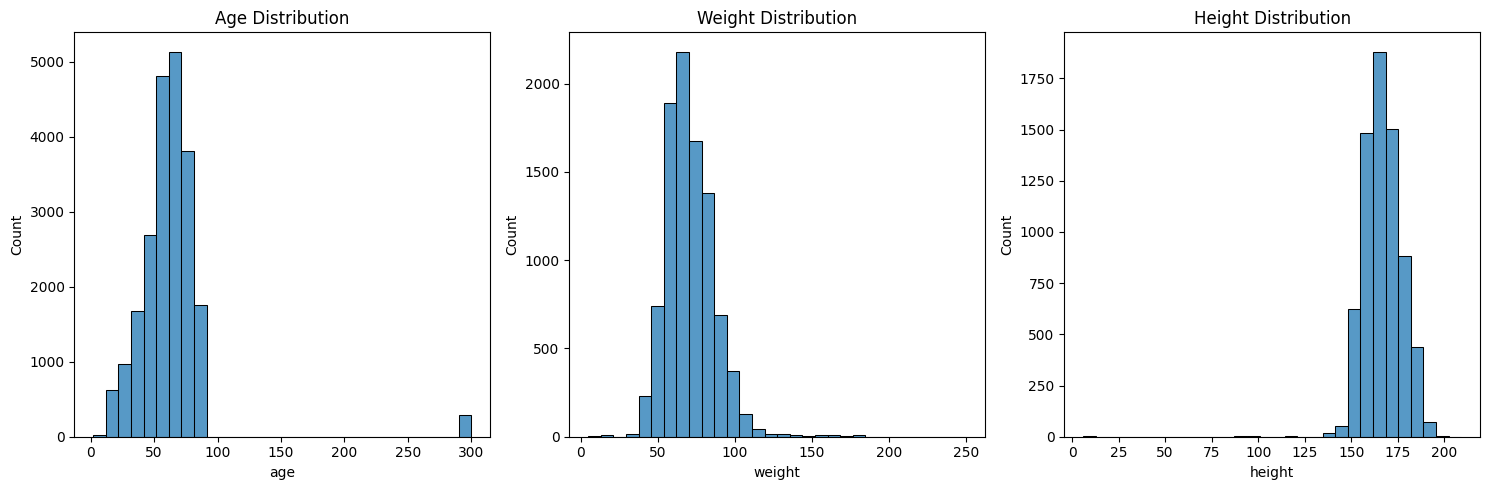

Missing Values:
age       0.000000
weight    0.567824
height    0.680077
dtype: float64


In [2]:
# Check Age, Height, Weight
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['age'], bins=30, ax=axes[0]).set_title('Age Distribution')
sns.histplot(df['weight'], bins=30, ax=axes[1]).set_title('Weight Distribution')
sns.histplot(df['height'], bins=30, ax=axes[2]).set_title('Height Distribution')

plt.tight_layout()
plt.show()

print("Missing Values:")
print(df[['age', 'weight', 'height']].isnull().mean())

## 2. Drug & History Extraction
We will replicate the logic from `PTBXLDatasetFusion` to see how many positive samples we get.

In [3]:
def extract_flags(row):
    # Pacemaker
    has_pace = 0
    if isinstance(row['pacemaker'], str) and 'pacemaker' in row['pacemaker'].lower():
        has_pace = 1
        
    # Drugs (from scp_codes)
    dig = 0
    qu = 0
    try:
        scp = ast.literal_eval(row['scp_codes'])
        if 'DIG' in scp: dig = 1
        if 'QU' in scp: qu = 1
    except:
        pass
        
    return pd.Series([has_pace, dig, qu], index=['Pacemaker', 'Digoxin', 'Quinidine'])

flags = df.apply(extract_flags, axis=1)
print("Flag Counts:")
print(flags.sum())

Flag Counts:
Pacemaker    285
Digoxin      181
Quinidine      0
dtype: int64


## 3. Correlation Check
Do patients on Digoxin actually have more 'MI' labels? (Or false positives?)
Let's see the ground truth.

In [4]:
# Load mappings
scp_df = pd.read_csv(os.path.join(DATA_DIR, 'scp_statements.csv'), index_col=0)
mapping = scp_df[scp_df.diagnostic_class.notnull()].diagnostic_class.to_dict()

def get_class(scp_str):
    try:
        d = ast.literal_eval(scp_str)
        for k in d:
            if k in mapping and mapping[k] == 'MI':
                return 1
    except:
        pass
    return 0

df['Has_MI'] = df['scp_codes'].apply(get_class)

# Join with flags
analysis = pd.concat([df['Has_MI'], flags], axis=1)

print("MI Rate in General Population:", analysis['Has_MI'].mean())
print("MI Rate in Digoxin Users:", analysis[analysis['Digoxin']==1]['Has_MI'].mean())

print("\nInterpretation: If Digoxin users have a very different rate, the model MUST know this context.")

MI Rate in General Population: 0.2508830680306436
MI Rate in Digoxin Users: 0.24861878453038674

Interpretation: If Digoxin users have a very different rate, the model MUST know this context.


## 4. Risk Correlation Heatmap
Let's see the big picture. Which features correlate with which diseases?

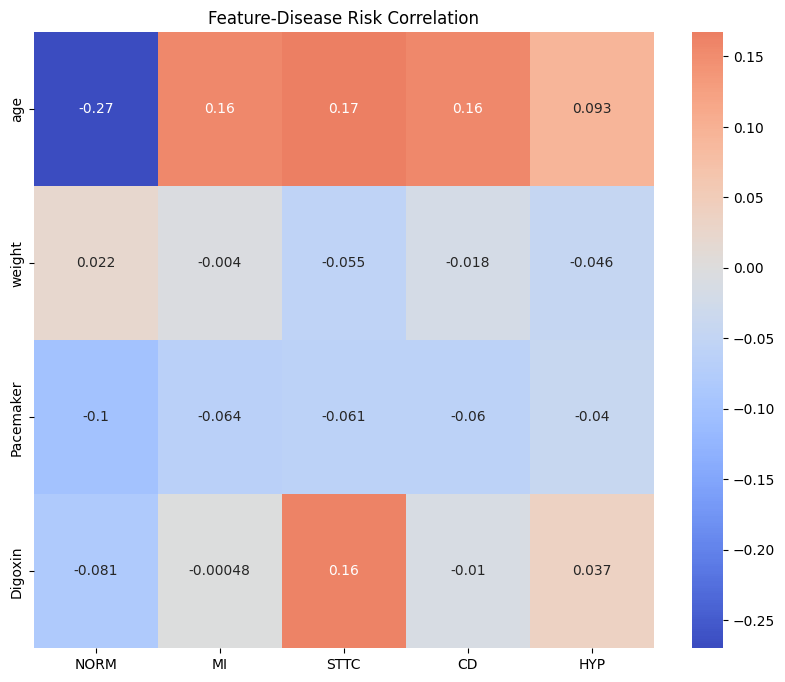

In [5]:
# Get all labels
lbl_map = {'NORM': 0, 'MI': 1, 'STTC': 2, 'CD': 3, 'HYP': 4}
def get_all_labels(scp_str):
    y = np.zeros(5)
    try:
        d = ast.literal_eval(scp_str)
        for k in d:
            if k in mapping:
                diag = mapping[k]
                if diag in lbl_map:
                    y[lbl_map[diag]] = 1
    except:
        pass
    return pd.Series(y, index=lbl_map.keys())

labels = df['scp_codes'].apply(get_all_labels)

# Join Features (Age, Weight, Flags) + Labels
feats = df[['age', 'weight']].copy()
data_viz = pd.concat([feats, flags, labels], axis=1)

# Compute Correlation
corr = data_viz.corr()

# Plot Heatmap (Focus on Feature-Label interaction)
plt.figure(figsize=(10, 8))
sns.heatmap(corr.loc[['age', 'weight', 'Pacemaker', 'Digoxin'], ['NORM', 'MI', 'STTC', 'CD', 'HYP']], 
            annot=True, cmap='coolwarm', center=0)
plt.title("Feature-Disease Risk Correlation")
plt.show()

## 5. The Pacemaker Proof
Does having a Pacemaker guarantee a 'Conduction Disturbance' label?

In [6]:
pace_patients = data_viz[data_viz['Pacemaker'] == 1]
cd_rate = pace_patients['CD'].mean()
print(f"Pacemaker Patients: {len(pace_patients)}")
print(f"Percentage with CD Label: {cd_rate*100:.1f}%")

if cd_rate > 0.9:
    print("✅ Validated: Pacemaker is a near-perfect proxy for CD.")
else:
    print("⚠️ Warning: Pacemaker logic implies non-CD conditions.")

Pacemaker Patients: 285
Percentage with CD Label: 0.7%
⚠️ Warning: Pacemaker logic implies non-CD conditions.
